# Firedrake 中的并行计算

## 终端中并行执行 Firedrake 程序

Firedrake 启动并行计算只需在终端中运行以下命令:

```
mpiexec -n <number-of-process> python3 /path/to/your/script.py
```

下面以求解 Poisson 方程的程序为例, 将以下代码保存为文件 `poisson.py`

```python
from firedrake import *

N = 8
test_mesh = RectangleMesh(nx=N, ny=N, Lx=1, Ly=1)
x, y = SpatialCoordinate(test_mesh)
f = sin(pi*x)*sin(pi*y)
g = Constant(0)

V = FunctionSpace(test_mesh, 'CG', degree=1)

u, v = TrialFunction(V), TestFunction(V)
a = inner(grad(u), grad(v))*dx
L = inner(f, v)*dx

bc = DirichletBC(V, g=g, sub_domain='on_boundary')

u_h = Function(V, name='u_h')
solve(a == L, u_h, bcs=bc)
output = VTKFile('data/result.pvd')
output.write(u_h)
```

如果想使用 2 个进程进行计算, 激活 Firedrake 环境后，运行如下命令：
```
mpiexec -n 2 python3 poisson.py
```

求解结果将保存在 `data/result.pvd` 文件中. 在 `data` 目录下会生成一个 `result` 文件夹,
真正的计算结果文件保存在该文件夹中, 每个进程对应一个结果文件. `result.pvd` 文件只是这些结果文件的索引.

Firedrake 使用 PETSc 的 DMPlex 来管理网格.
在并行计算中, 计算区域会被划分为多个子区域 (默认情况下区域间有交叠),
并分配给不同的进程, 因此每个进程的结果文件仅包含该进程对应区域的结果.

<!--
```bash
MPICH_NO_LOCAL=1 mpiexec -n 16 -bind-to core -map-by socket python /path/to/script.py
```
-->

### 并行时的一些注意事项


#### 并行输出

参考 [py/intro_utils.py](py/intro_utils.py)

1. 并行时只输出一次

   ```
   PETSc.Sys.Print("This is the message will only show once!")
   ```

2. 每个进程都输出

   ```
   rank, size = COMM_WORLD.rank, COMM_WORLD.size
   PETSc.Sys.syncPrint(f"[{rank}/{size}] This is the message from rank {rank}!")
   PETSc.Sys.syncFlush()
   ```

#### 指定进程操作

如果需要在某个特定进程上执行某些操作或计算, 可以使用条件语句. 例如, 只在第 0 号进程上进行绘图操作:

```python
if COMM_WORLD.rank == 0:
    triplot(...)
```

## 在 Jupyter-notebook/Jupyter-lab 中并行执行 Firedrake 代码

在 Jupyter 交互环境中, 我们可以方便地对串行代码进行测试, 从而进行快速验证.
为了在 Jupyter 环境下运行并行程序, `ipyparallel` 包提供了强大的支持,
它能够帮助我们在 Jupyter 中验证并行代码, 同时加深我们对 Firedrake 并行机制的理解.


### 安装配置 `ipyparallel`

1. 激活 Firedrake 环境.
    ```bash
    source /path/to/firedrake/bin/activate
    ```

2. 安装 `ipyparallel`
    
    ```bash
    pip install ipyparallel
    ```

3. 创建 `mpi` 配置文件 (profile)
    
    ```bash
    ipython profile create --parallel --profile=mpi
    ```
    
    运行此命令后，你将看到类似如下的输出
    
    ```bash
    [ProfileCreate] Generating default config file: 
        PosixPath('/home/<your-user-name>/.ipython/profile_mpi/ipython_config.py')
    [ProfileCreate] Generating default config file: 
        PosixPath('/home/<your-user-name>/.ipython/profile_mpi/ipython_kernel_config.py')
    [ProfileCreate] Generating default config file: 
        PosixPath('/home/<your-user-name>/.ipython/profile_mpi/ipcontroller_config.py')
    [ProfileCreate] Generating default config file: 
        PosixPath('/home/<your-user-name>/.ipython/profile_mpi/ipengine_config.py')
    [ProfileCreate] Generating default config file: 
        PosixPath('/home/<your-user-name>/.ipython/profile_mpi/ipcluster_config.py')
    ```

4. 在文件 `.ipython/profile_mpi/ipengine_config.py` 的开头添加以下代码
    
    ```python
    from firedrake import *
    from firedrake.petsc import PETSc
    ```

5. 在 `.ipython/profile_mpi/ipcluster_config.py` 中设置默认引擎 (engines) 为 `mpi`. 

   可以在文件中搜索 `engine_launcher_class`, 并将其编辑为如下内容
    
    ```python
    #    - sshproxy: ipyparallel.cluster.launcher.SSHProxyEngineSetLauncher
    #    - winhpc: ipyparallel.cluster.launcher.WindowsHPCEngineSetLauncher
    #  Default: 'ipyparallel.cluster.launcher.LocalEngineSetLauncher'
    c.Cluster.engine_launcher_class = 'mpi'
    ```

### 测试 `ipyparallel`

启动并连接 `Cluster`.

In [1]:
import ipyparallel as ipp

cluster = ipp.Cluster(profile="mpi", n=2)
client = cluster.start_and_connect_sync()

Starting 2 engines with <class 'ipyparallel.cluster.launcher.MPIEngineSetLauncher'>
100%|██████████| 2/2 [00:05<00:00,  2.90s/engine]


在配置好 `ipyparallel` 并启动集群后, 可以通过 Jupyter 中的魔法指令 `%%px` 在多个进程上并行执行代码.
`%%px` 是 `ipyparallel` 提供的魔法命令, 能够在所有并行引擎上同时执行代码.
`--block` 参数用于同步执行代码, 确保代码在所有进程上完成后再继续执行后续命令.

In [2]:
%%px --block
from firedrake import *
from firedrake.petsc import PETSc
from mpi4py import MPI

mesh = RectangleMesh(8, 8, 1, 1)
PETSc.Sys.Print("This will only show onece!")

rank, size = mesh.comm.rank, mesh.comm.size
PETSc.Sys.syncPrint(f"[{rank}/{size}] This is the message from rank {rank}!")
PETSc.Sys.syncFlush()
PETSc.Sys.syncFlush()

[stdout:0] This will only show onece!
[0/2] This is the message from rank 0!
[1/2] This is the message from rank 1!


## 使用 ipyparallel 观察串行和并行过程

### 生成网格并画出网格

#### 串行

firedrake:WARNING OMP_NUM_THREADS is not set or is set to a value greater than 1, we suggest setting OMP_NUM_THREADS=1 to improve performance


DM Object: firedrake_default_topology 1 MPI process
  type: plex
firedrake_default_topology in 2 dimensions:
  Number of 0-cells per rank: 25
  Number of 1-cells per rank: 56
  Number of 2-cells per rank: 32
Labels:
  celltype: 3 strata with value/size (0 (25), 3 (32), 1 (56))
  depth: 3 strata with value/size (0 (25), 1 (56), 2 (32))
  Face Sets: 4 strata with value/size (1 (4), 3 (4), 4 (4), 2 (4))
  exterior_facets: 1 strata with value/size (1 (16))
  interior_facets: 1 strata with value/size (1 (40))


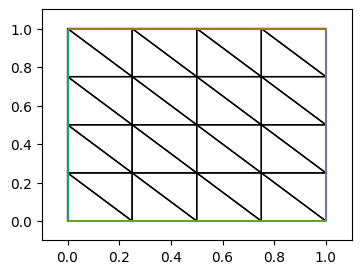

In [3]:
from firedrake import *
from firedrake.pyplot import triplot
from firedrake.petsc import PETSc
from mpi4py import MPI

import matplotlib.pyplot as plt

mesh = RectangleMesh(4, 4, 1, 1)
mesh.topology_dm.view()
fig, axes = plt.subplots(figsize=[4, 3])
c = triplot(mesh, axes=axes)
xlim = axes.set_xlim([-0.1,1.1])
ylim = axes.set_ylim([-0.1,1.1])

#### 并行

[output:1]

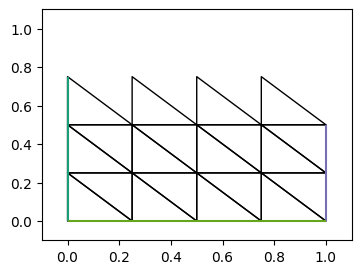

[stdout:0] DM Object: firedrake_default_topology 2 MPI processes
  type: plex
firedrake_default_topology in 2 dimensions:
  Number of 0-cells per rank: 15 15
  Number of 1-cells per rank: 30 30
  Number of 2-cells per rank: 16 16
Labels:
  depth: 3 strata with value/size (0 (15), 1 (30), 2 (16))
  celltype: 3 strata with value/size (0 (15), 1 (30), 3 (16))
  Face Sets: 3 strata with value/size (1 (2), 2 (2), 4 (4))
  exterior_facets: 1 strata with value/size (1 (8))
  interior_facets: 1 strata with value/size (1 (22))


[output:0]

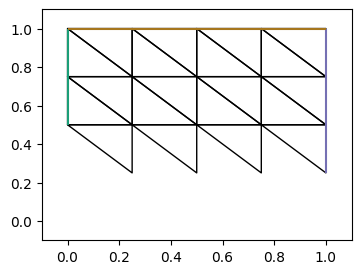

In [4]:
%%px --block
from firedrake import *
from firedrake.pyplot import triplot
from firedrake.petsc import PETSc
from mpi4py import MPI

import matplotlib.pyplot as plt

mesh = RectangleMesh(4, 4, 1, 1)
mesh.topology_dm.view()
fig, axes = plt.subplots(figsize=[4, 3])
c = triplot(mesh, axes=axes)
xlim = axes.set_xlim([-0.1,1.1])
ylim = axes.set_ylim([-0.1,1.1])

可以看到上面并行中两个网格图是整体网格的一部分, 且有重叠部分.

### 定义变分问题

#### 串行

In [5]:
V1 = VectorFunctionSpace(mesh, 'CG', 1)
V2 = FunctionSpace(mesh, 'CG', 2)
W = MixedFunctionSpace([V1, V2])  # W = V1*V2
u1, u2 = TrialFunctions(W)
v1, v2 = TestFunctions(W)
a = dot(u1, v1)*dx + u2*v2*dx

x, y = SpatialCoordinate(mesh)
f = dot(as_vector((sin(x), cos(y))), v1)*dx + cos(y)*v2*dx

bc = DirichletBC(W.sub(0), 0, 1)
uh = Function(W)
problem = LinearVariationalProblem(a, f, uh, bcs=bc)

#### 并行

In [6]:
%%px --block
V1 = VectorFunctionSpace(mesh, 'CG', 1)
V2 = FunctionSpace(mesh, 'CG', 2)
W = MixedFunctionSpace([V1, V2])  # W = V1*V2
u1, u2 = TrialFunctions(W)
v1, v2 = TestFunctions(W)
a = dot(u1, v1)*dx + u2*v2*dx

x, y = SpatialCoordinate(mesh)
f = dot(as_vector((sin(x), cos(y))), v1)*dx + cos(y)*v2*dx

bc = DirichletBC(W.sub(0), 0, 1)
uh = Function(W)
problem = LinearVariationalProblem(a, f, uh, bcs=bc)

### 函数空间维度

函数空间 V1 和 V2 中的自由度, 可以通过调用函数 dim 得到

In [7]:
rank, size = mesh.comm.rank, mesh.comm.size
PETSc.Sys.Print(f'Number of dofs of V1: {V1.dim()}')
PETSc.Sys.syncPrint(f'[{rank}/{size}] V1 Node count: {V1.node_count}; V1 Dof count: {V1.dof_count}')
PETSc.Sys.syncFlush()

Number of dofs of V1: 50
[0/1] V1 Node count: 25; V1 Dof count: 50


In [8]:
%%px --block
rank, size = mesh.comm.rank, mesh.comm.size
PETSc.Sys.Print(f'Number of dofs of V1: {V1.dim()}')
PETSc.Sys.syncPrint(f'[{rank}/{size}] V1 Node count: {V1.node_count}; V1 Dof count: {V1.dof_count}')
PETSc.Sys.syncFlush()

[stdout:0] Number of dofs of V1: 50
[0/2] V1 Node count: 19; V1 Dof count: 38
[1/2] V1 Node count: 19; V1 Dof count: 38


### 节点集和自由度数据集

In [9]:
PETSc.Sys.syncPrint(f'[{rank}/{size}] V1: {str(V1.node_set)}')
PETSc.Sys.syncPrint(f'[{rank}/{size}]     {repr(V1.node_set)}')
PETSc.Sys.syncPrint(f'[{rank}/{size}] V1: {str(V1.dof_dset)}')
PETSc.Sys.syncPrint(f'[{rank}/{size}]     {repr(V1.dof_dset)}')
PETSc.Sys.syncFlush()

[0/1] V1: OP2 Set: set_#x13c2089b0 with size 25
[0/1]     Set((np.int64(25), np.int64(25), np.int64(25)), 'set_#x13c2089b0')
[0/1] V1: OP2 DataSet: None_nodes_dset on set OP2 Set: set_#x13c2089b0 with size 25, with dim (2,)
[0/1]     DataSet(Set((np.int64(25), np.int64(25), np.int64(25)), 'set_#x13c2089b0'), (2,), 'None_nodes_dset')


In [10]:
%%px --block
PETSc.Sys.syncPrint(f'[{rank}/{size}] V1: {str(V1.node_set)}')
PETSc.Sys.syncPrint(f'[{rank}/{size}]     {repr(V1.node_set)}')
PETSc.Sys.syncPrint(f'[{rank}/{size}] V1: {str(V1.dof_dset)}')
PETSc.Sys.syncPrint(f'[{rank}/{size}]     {repr(V1.dof_dset)}')
PETSc.Sys.syncFlush()

[stdout:0] [0/2] V1: OP2 Set: set_#x16876ffb0 with size 10
[0/2]     Set((np.int64(5), np.int64(10), np.int64(19)), 'set_#x16876ffb0')
[0/2] V1: OP2 DataSet: None_nodes_dset on set OP2 Set: set_#x16876ffb0 with size 10, with dim (2,)
[0/2]     DataSet(Set((np.int64(5), np.int64(10), np.int64(19)), 'set_#x16876ffb0'), (2,), 'None_nodes_dset')
[1/2] V1: OP2 Set: set_#x17065ecc0 with size 15
[1/2]     Set((np.int64(10), np.int64(15), np.int64(19)), 'set_#x17065ecc0')
[1/2] V1: OP2 DataSet: None_nodes_dset on set OP2 Set: set_#x17065ecc0 with size 15, with dim (2,)
[1/2]     DataSet(Set((np.int64(10), np.int64(15), np.int64(19)), 'set_#x17065ecc0'), (2,), 'None_nodes_dset')


#### Size of Set and Data Set

In [11]:
# Reference:
#   https://github.com/OP2/PyOP2/blob/31471a606a852aed250b05574d1fc2a2874eec31/pyop2/types/set.py#L30
#
# The division of set elements is:
#
#        [0, CORE)
#        [CORE, OWNED)
#        [OWNED, GHOST)
#
# Attribute of dof_dset
#   core_size: Core set size.  Owned elements not touching halo elements.
#   size: Set size, owned elements.
#   total_size: Set size including ghost elements.
#   sizes: (core_size, size, total_size)

In [12]:
node_set = V1.node_set
msg = f'core size: {node_set.core_size}, size: {node_set.size}, total size: {node_set.total_size}'
# another size: node_set.constrained_size
PETSc.Sys.syncPrint(f'[{rank}/{size}] {msg}')
PETSc.Sys.syncFlush()

[0/1] core size: 25, size: 25, total size: 25


In [13]:
%%px --block
node_set = V1.node_set
msg = f'core size: {node_set.core_size}, size: {node_set.size}, total size: {node_set.total_size}'
PETSc.Sys.syncPrint(f'[{rank}/{size}] {msg}')
PETSc.Sys.syncFlush()

[stdout:0] [0/2] core size: 5, size: 10, total size: 19
[1/2] core size: 10, size: 15, total size: 19


In [14]:
dof_dset = V1.dof_dset
size_msg = f'core size: {dof_dset.core_size}, size: {dof_dset.size}, total size: {dof_dset.total_size}'
# dim: shape tuple of the values for each element, cdim: product of dim tuple
dim_msg = f'dim: {dof_dset.dim}, cdim: {dof_dset.cdim}'
PETSc.Sys.syncPrint(f'[{rank}/{size}] {size_msg}, {dim_msg}')
PETSc.Sys.syncFlush()

[0/1] core size: 25, size: 25, total size: 25, dim: (2,), cdim: 2


In [15]:
%%px --block
dof_dset = V1.dof_dset
size_msg = f'core size: {dof_dset.core_size}, size: {dof_dset.size}, total size: {dof_dset.total_size}'
# dim: shape tuple of the values for each element, cdim: product of dim tuple
dim_msg = f'dim: {dof_dset.dim}, cdim: {dof_dset.cdim}'
PETSc.Sys.syncPrint(f'[{rank}/{size}] {size_msg}, {dim_msg}')
PETSc.Sys.syncFlush()

[stdout:0] [0/2] core size: 5, size: 10, total size: 19, dim: (2,), cdim: 2
[1/2] core size: 10, size: 15, total size: 19, dim: (2,), cdim: 2


#### ISES of Data Set

In [16]:
# Reference:
#   https://github.com/OP2/PyOP2/blob/31471a606a852aed250b05574d1fc2a2874eec31/pyop2/types/dataset.py#L145
#
# field_ises:
#   A list of PETSc ISes defining the global indices for each set in the DataSet.
#   Used when extracting blocks from matrices for solvers.
#
# local_ises:
#   A list of PETSc ISes defining the local indices for each set in the DataSet.
#   Used when extracting blocks from matrices for assembly.

In [17]:
local_ises_msg = f'{[_.getIndices() for _ in W.dof_dset.local_ises]}'
PETSc.Sys.syncPrint(f'[{rank}/{size}] {local_ises_msg}')
PETSc.Sys.syncFlush()

[0/1] [array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49],
      dtype=int32), array([ 50,  51,  52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,
        63,  64,  65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,
        76,  77,  78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,
        89,  90,  91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101,
       102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114,
       115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127,
       128, 129, 130], dtype=int32)]


In [18]:
%%px --block
local_ises_msg = f'{[_.getIndices() for _ in W.dof_dset.local_ises]}'
PETSc.Sys.syncPrint(f'[{rank}/{size}] {local_ises_msg}')
PETSc.Sys.syncFlush()

[stdout:0] [0/2] [array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37], dtype=int32), array([38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54,
       55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71,
       72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88,
       89, 90, 91, 92, 93, 94], dtype=int32)]
[1/2] [array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37], dtype=int32), array([38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54,
       55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71,
       72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88,
       89, 90, 91, 92, 93, 94], dtype=int32)]


In [19]:
field_ises_msg = f'{[_.getIndices() for _ in W.dof_dset.field_ises]}'
PETSc.Sys.syncPrint(f'[{rank}/{size}] {field_ises_msg}')
PETSc.Sys.syncFlush()

[0/1] [array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49],
      dtype=int32), array([ 50,  51,  52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,
        63,  64,  65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,
        76,  77,  78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,
        89,  90,  91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101,
       102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114,
       115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127,
       128, 129, 130], dtype=int32)]


In [20]:
%%px --block
field_ises_msg = f'{[_.getIndices() for _ in W.dof_dset.field_ises]}'
PETSc.Sys.syncPrint(f'[{rank}/{size}] {field_ises_msg}')
PETSc.Sys.syncFlush()

[stdout:0] [0/2] [array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19], dtype=int32), array([20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36,
       37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53,
       54, 55], dtype=int32)]
[1/2] [array([56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72,
       73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85], dtype=int32), array([ 86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  96,  97,  98,
        99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111,
       112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124,
       125, 126, 127, 128, 129, 130], dtype=int32)]


#### Local to Global Map

In [33]:
[W.dof_dset.lgmap.apply(_) for _ in W.dof_dset.local_ises]

[array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49],
       dtype=int32),
 array([ 50,  51,  52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,
         63,  64,  65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,
         76,  77,  78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,
         89,  90,  91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101,
        102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114,
        115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127,
        128, 129, 130], dtype=int32)]

In [34]:
%%px --block
[W.dof_dset.lgmap.apply(_) for _ in W.dof_dset.local_ises]

Out[1:12]: 
[array([56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72,
        73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 18, 19, 16, 17,
        14, 15, 12, 13], dtype=int32),
 array([ 86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  96,  97,  98,
         99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111,
        112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124,
        125, 126, 127, 128, 129, 130,  55,  54,  53,  51,  50,  49,  47,
         46,  45,  43,  42,  40], dtype=int32)]

Out[0:12]: 
[array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 84, 85, 82, 83, 74, 75, 80, 81, 70, 71, 78, 79, 66, 67,
        76, 77, 62, 63], dtype=int32),
 array([ 20,  21,  22,  23,  24,  25,  26,  27,  28,  29,  30,  31,  32,
         33,  34,  35,  36,  37,  38,  39,  40,  41,  42,  43,  44,  45,
         46,  47,  48,  49,  50,  51,  52,  53,  54,  55, 130, 129, 121,
        120, 128, 119, 127, 116, 112, 126, 111, 125, 108, 104, 124, 103,
        123, 122, 100,  96,  94], dtype=int32)]

#### Layout Vector of Data Set

In [21]:
# dof_dset.layout_vec.getSizes()
vec_msg = f'Local Size: {dof_dset.layout_vec.getLocalSize()}, Size: {dof_dset.layout_vec.getSize()}'
PETSc.Sys.syncPrint(f'[{rank}/{size}] {vec_msg}')
PETSc.Sys.syncFlush()

[0/1] Local Size: 50, Size: 50


In [22]:
%%px --block
# dof_dset.layout_vec.getSizes()
vec_msg = f'Local Size: {dof_dset.layout_vec.getLocalSize()}, Size: {dof_dset.layout_vec.getSize()}'
PETSc.Sys.syncPrint(f'[{rank}/{size}] {vec_msg}')
PETSc.Sys.syncFlush()

[stdout:0] [0/2] Local Size: 20, Size: 50
[1/2] Local Size: 30, Size: 50


### 定义 Solver

In [37]:
def post_jacobian_callback(X, J):
    # X: vector (gauss value)
    # J: mat
    #
    # mat reference:
    #   https://petsc.org/main/petsc4py/reference/petsc4py.PETSc.Mat.html

    PETSc.Sys.Print("post jacobian callback begin")
    rank, size = COMM_WORLD.rank, COMM_WORLD.size
    bc = DirichletBC(W.sub(0), 0, ((1, 3),))
    PETSc.Sys.syncPrint(f"[{rank}/{size}] bc nodes: {bc.nodes}")
    PETSc.Sys.syncFlush()

    # J.setValue(i, j, 1, PETSc.InsertMode.ADD_VALUES)
    # J.setValueLocal(i, j, 1)
    # J.setValueLocal(i, j, 1, PETSc.InsertMode.ADD_VALUES)
    # J.assemble()
    PETSc.Sys.Print("post jacobian callback end")


def post_function_callback(X, F):
    # X: vector (gauss value)
    # F: vector
    #
    # vec reference:
    #   https://petsc.org/main/petsc4py/reference/petsc4py.PETSc.Vec.html

    PETSc.Sys.Print("post function callback begin")
    F.zeroEntries()
    PETSc.Sys.Print("post function callback end")

solver = LinearVariationalSolver(problem,
                                 post_jacobian_callback=post_jacobian_callback,
                                 post_function_callback=post_function_callback)
solver.solve()

post function callback begin
post function callback end
post jacobian callback begin
[0/1] bc nodes: [0]
post jacobian callback end


In [36]:
%%px --block
def post_jacobian_callback(X, J):
    # X: vector (gauss value)
    # J: mat
    #
    # mat reference:
    #   https://petsc.org/main/petsc4py/reference/petsc4py.PETSc.Mat.html

    PETSc.Sys.Print("post jacobian callback begin")
    rank, size = COMM_WORLD.rank, COMM_WORLD.size
    bc = DirichletBC(W.sub(0), 0, ((1, 3),))
    PETSc.Sys.syncPrint(f"[{rank}/{size}] bc nodes: {bc.nodes}")
    PETSc.Sys.syncFlush()

    # J.setValue(i, j, 1, PETSc.InsertMode.ADD_VALUES)
    # J.setValueLocal(i, j, 1)
    # J.setValueLocal(i, j, 1, PETSc.InsertMode.ADD_VALUES)
    # J.assemble()
    PETSc.Sys.Print("post jacobian callback end")


def post_function_callback(X, F):
    # X: vector (gauss value)
    # F: vector
    #
    # vec reference:
    #   https://petsc.org/main/petsc4py/reference/petsc4py.PETSc.Vec.html

    PETSc.Sys.Print("post function callback begin")
    F.zeroEntries()
    PETSc.Sys.Print("post function callback end")

solver = LinearVariationalSolver(problem,
                                 post_jacobian_callback=post_jacobian_callback,
                                 post_function_callback=post_function_callback)
solver.solve()

[stdout:0] post function callback begin
post function callback end
post jacobian callback begin
[0/2] bc nodes: []
[1/2] bc nodes: [0]
post jacobian callback end


#### Context of the Solver

In [41]:
ctx = solver._ctx
ctx._jac.petscmat.getSizes()

((131, 131), (131, 131))

In [42]:
%%px --block
ctx = solver._ctx
ctx._jac.petscmat.getSizes()

Out[1:15]: ((75, 131), (75, 131))

Out[0:15]: ((56, 131), (56, 131))